In [1]:
import os
import zipfile
import wget
import tensorflow as tf
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, VGG16, InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
url = "https://storage.googleapis.com/didow-ml-datasets/dylexia-handwriting-dataset.zip"
filename = wget.download(url)

In [3]:
local_zip = 'dylexia-handwriting-dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('./Dataset/')
zip_ref.close()

In [4]:
base_dir = './Dataset/Gambo'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Test')

# Directory with our training cat/dog pictures
train_Corrected_dir = os.path.join(train_dir, 'Corrected')
train_Normal_dir = os.path.join(train_dir, 'Normal')
train_Reversal_dir = os.path.join(train_dir, 'Reversal')

# Directory with our validation cat/dog pictures
validation_Corrected_dir = os.path.join(validation_dir, 'Corrected')
validation_Normal_dir = os.path.join(validation_dir, 'Normal')
validation_Reversal_dir = os.path.join(validation_dir, 'Reversal')

In [5]:
train_Corrected_fnames = os.listdir( train_Corrected_dir )
train_Normal_fnames = os.listdir( train_Normal_dir )
train_Reversal_fnames = os.listdir( train_Reversal_dir )

print(train_Corrected_fnames[:10])
print(train_Normal_fnames[:10])
print(train_Reversal_fnames[:10])

['4_1.png', '4_10.png', '4_100.png', '4_1000.png', '4_1001.png', '4_1002.png', '4_1003.png', '4_1004.png', '4_1005.png', '4_1006.png']
['A-0.png', 'A-1.png', 'A-10.png', 'A-1000.png', 'A-1001.png', 'A-1002.png', 'A-1004.png', 'A-1005.png', 'A-1006.png', 'A-1007.png']
['1_1.png', '1_10.png', '1_100.png', '1_1000.png', '1_10000.png', '1_10001.png', '1_10002.png', '1_10003.png', '1_10004.png', '1_10005.png']


In [6]:
print('total training Corrected images :', len(os.listdir(train_Corrected_dir)))
print('total training Normal images :', len(os.listdir(train_Normal_dir)))
print('total training Reversal images :', len(os.listdir(train_Reversal_dir)))

print('total validation Corrected images :', len(os.listdir(validation_Corrected_dir)))
print('total validation Normal images :', len(os.listdir(validation_Normal_dir)))
print('total validation Reversal images :', len(os.listdir(validation_Reversal_dir)))

total training Corrected images : 65534
total training Normal images : 39334
total training Reversal images : 46781
total validation Corrected images : 19284
total validation Normal images : 19557
total validation Reversal images : 17882


In [7]:
%matplotlib inline

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 5
ncols = 5

pic_index = 0 # Index for iterating over images

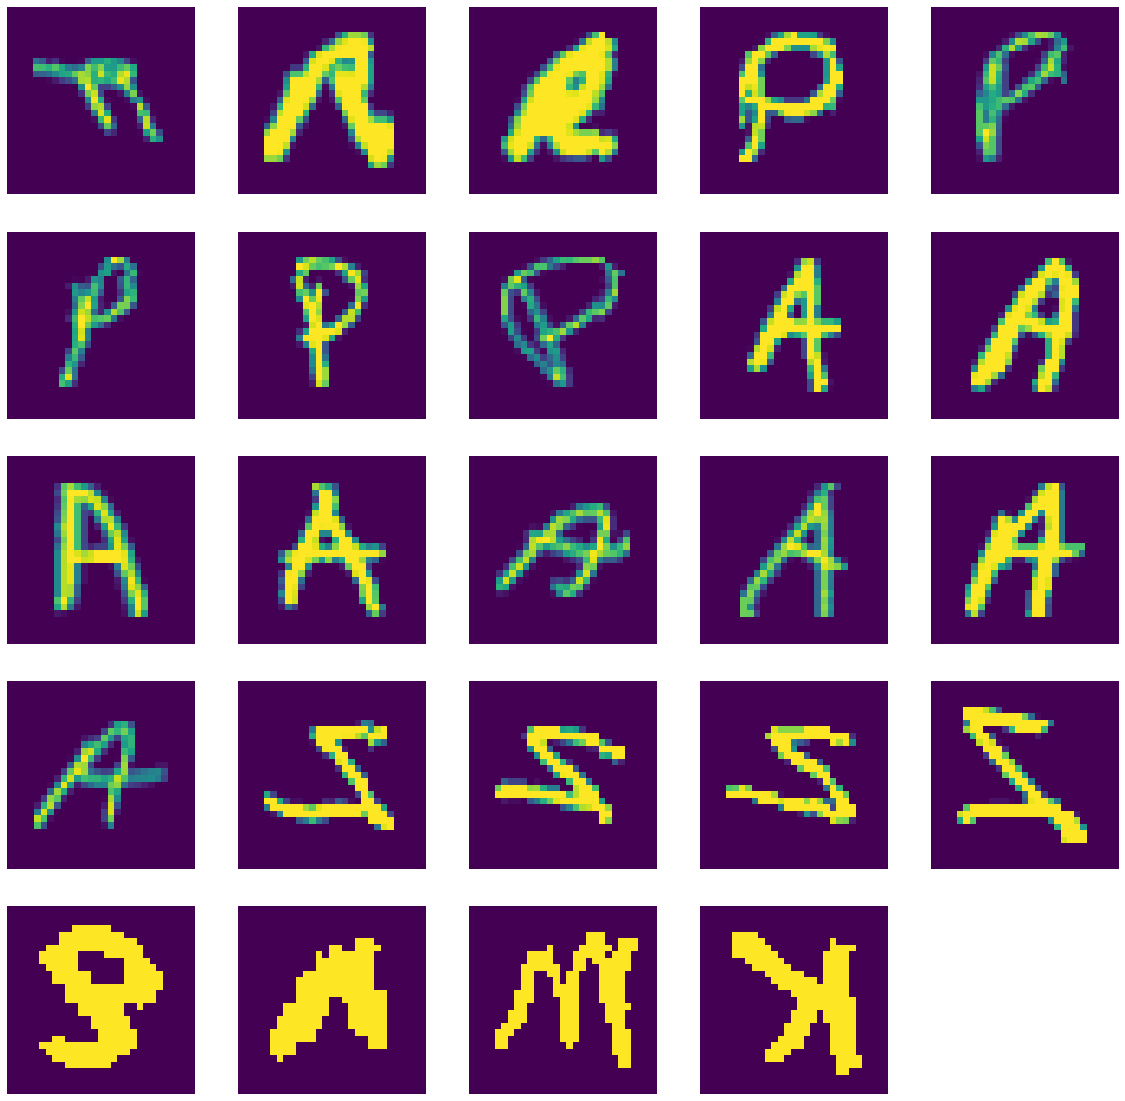

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_Corrected_pix = [os.path.join(train_Corrected_dir, fname) 
                for fname in train_Corrected_fnames[ pic_index-8:pic_index] 
               ]

next_Normal_pix = [os.path.join(train_Normal_dir, fname) 
                for fname in train_Normal_fnames[ pic_index-8:pic_index]
               ]
next_Reversal_pix = [os.path.join(train_Reversal_dir, fname) 
                for fname in train_Reversal_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_Corrected_pix+next_Normal_pix+next_Reversal_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [9]:

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    # color_mode='grayscale',
                                                    class_mode='categorical',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=32,
                                                        #  color_mode='grayscale',
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150))


Found 151649 images belonging to 3 classes.
Found 56723 images belonging to 3 classes.


In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 98):
      print("\nReached 98% accuracy. Stop Training")
      self.model.stop_training = True

callbacks = myCallback()

In [11]:


pre_trained_model= VGG16(input_shape=(150,150,3),
                        include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable=False

#flatten layer
x= layers.Flatten()(pre_trained_model.output)
#fully connected layer
x= layers.Dense(1024, activation='relu')(x)
x= layers.Dropout(0.5)(x)
x= layers.Dense(3, activation='softmax')(x)

model= Model(pre_trained_model.input,x)
model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [12]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=(151649/1024), # 151649 adalah jumlah data gambar yg ada di folder train secara keseluruhan
                              epochs=20,
                              validation_steps=(56273/1024), #56273 adalah jumlah data gambar yg ada di folder test secara keseluruhan
                              callbacks=[callbacks],
                              verbose=1)

Epoch 1/20
148/148 [==============================] - 54s 322ms/step - loss: 0.6980 - accuracy: 0.7641 - val_loss: 0.6464 - val_accuracy: 0.7324
Epoch 2/20
148/148 [==============================] - 53s 352ms/step - loss: 0.3995 - accuracy: 0.8456 - val_loss: 0.5104 - val_accuracy: 0.7898
Epoch 3/20
148/148 [==============================] - 39s 264ms/step - loss: 0.3569 - accuracy: 0.8649 - val_loss: 0.5142 - val_accuracy: 0.7955
Epoch 4/20
148/148 [==============================] - 44s 296ms/step - loss: 0.3502 - accuracy: 0.8622 - val_loss: 0.4609 - val_accuracy: 0.8176
Epoch 5/20
148/148 [==============================] - 37s 249ms/step - loss: 0.3205 - accuracy: 0.8744 - val_loss: 0.4511 - val_accuracy: 0.8153
Epoch 6/20
148/148 [==============================] - 45s 306ms/step - loss: 0.2986 - accuracy: 0.8811 - val_loss: 0.4879 - val_accuracy: 0.8142
Epoch 7/20
148/148 [==============================] - 565s 4s/step - loss: 0.3054 - accuracy: 0.8838 - val_loss: 0.4439 - val_accu

Text(0.5, 1.0, 'Training and validation loss')

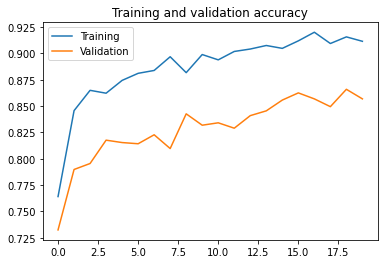

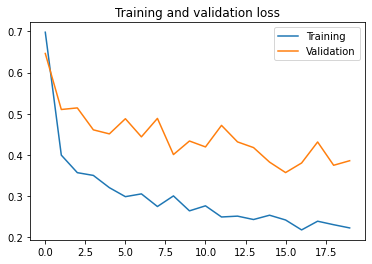

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

In [14]:
test_loss, test_accuracy = model.evaluate(validation_generator, verbose = 2)

print("Test Loss: ",test_loss)
print("Test Accuracy: ",test_accuracy)

1773/1773 - 295s - loss: 0.4012 - accuracy: 0.8507 - 295s/epoch - 166ms/step
Test Loss:  0.40117520093917847
Test Accuracy:  0.8507307171821594


In [15]:
# EXERCISE: Save the trained model as a Keras HDF5 file. 

saved_model_path = "./Model/dyslexia/1/dyslexia_model.h5"

# YOUR CODE HERE
model.save(saved_model_path)